<a href="https://colab.research.google.com/github/JumpNShootMan/TF_MachineLearning/blob/master/TF_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importar dataset CIFAR10

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout, LSTM, SimpleRNN, Conv2D, MaxPooling2D, Conv2D
from keras.layers import *
from tensorflow.keras.utils import normalize
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import numpy as np
from random import randrange

from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV

from sklearn.cluster import KMeans
from scipy.stats import mode
from sklearn.metrics import accuracy_score

## Cargar el Dataset CIFAR10

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

## Normalización, Ajuste de forma (reshape) y muestreo de data

(50000, 32, 32, 3)
(50000, 1)


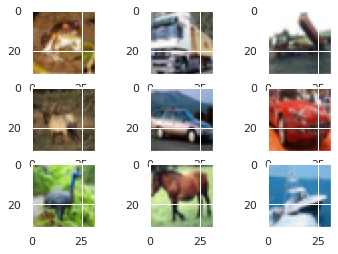

(50000, 1024, 3)
(50000, 1)


In [ ]:
print(x_train.shape)
print(y_train.shape)

#ut de untouched, sin tocar
x_train_ut = x_train
x_test_ut = x_test

for i in range(9):
	plt.subplot(330 + 1 + i)
	plt.imshow(x_train[i], cmap=plt.get_cmap('gray'))
plt.show()

x_train = x_train.reshape(50000,1024,3)
x_test = x_test.reshape(10000,1024,3)
x_train = x_train/255.0
x_test = x_test/255.0

print(x_train.shape)
print(y_train.shape)

In [ ]:
# Función para graficar las curvas de aprendizaje de las redes neuronales

def graphLearningCurve(modelHistory, name):
  plt.figure(figsize=[14,7])
  ax= plt.subplot(1,2,1)
  plt.plot(modelHistory.history['accuracy'])
  plt.plot(modelHistory.history['val_accuracy'])
  plt.title('Accuracy Modelo ' + name)
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  ax= plt.subplot(1,2,2)
  plt.plot(modelHistory.history['loss'])
  plt.plot(modelHistory.history['val_loss'])
  plt.title('Loss Modelo ' + name)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')
  plt.show()

In [ ]:
# Función para graficar las curvas de validación de los modelos que no son redes

def plotingValidationCurve(model, X, y, param_name, param_range, cv, scoring):
  train_scores, valid_scores = validation_curve(
    model, X, y, param_name=param_name, param_range=param_range,
    cv=cv, scoring=scoring)

  mean_training = np.mean(train_scores, axis=1) 
  mean_validation = np.mean(valid_scores, axis=1) 

  plt.plot(param_range, mean_training, '--', color="b",  label="Train score")
  plt.plot(param_range, mean_validation, color="g", label="Validation score")
  plt.xlabel(param_name)
  plt.ylabel("Score")
  plt.legend(loc="best")
  plt.show()

## Modelos Supervisados

### RNN

In [ ]:
model1 = Sequential()

#Modelo RNN
model1.add(SimpleRNN(32, input_shape=(x_train.shape[1:]), activation='relu', return_sequences=True))
model1.add(Dropout(0.2))
model1.add(SimpleRNN(32)) 
model1.add(Dropout(0.2))
model1.add(Flatten())
model1.add(Dense(32,activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(10,activation='softmax'))

opt = tf.keras.optimizers.Adam(lr = 1e-3, decay=1e-5)

model1.compile(loss='sparse_categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [ ]:
hist1 = model1.fit(x_train,y_train,epochs=3,validation_data=(x_test,y_test))

Epoch 1/3
1563/1563 [==============================] - 649s 415ms/step - loss: 2.1955 - accuracy: 0.1741 - val_loss: 2.1131 - val_accuracy: 0.2059
Epoch 2/3
1563/1563 [==============================] - 692s 443ms/step - loss: 2.1289 - accuracy: 0.2065 - val_loss: 2.0850 - val_accuracy: 0.2285
Epoch 3/3
1563/1563 [==============================] - 691s 442ms/step - loss: 2.1538 - accuracy: 0.2018 - val_loss: 2.1418 - val_accuracy: 0.2032


#### Evaluando RNN

In [ ]:
# impresión de precisión, recall y f1-score
y_pred = model1.predict(x_test, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_cate))

313/313 [==============================] - 26s 83ms/step
              precision    recall  f1-score   support

           0       0.36      0.01      0.01      1000
           1       0.19      0.22      0.20      1000
           2       0.19      0.00      0.01      1000
           3       0.20      0.13      0.16      1000
           4       0.15      0.19      0.17      1000
           5       0.26      0.03      0.05      1000
           6       0.17      0.15      0.16      1000
           7       0.19      0.48      0.27      1000
           8       0.28      0.56      0.37      1000
           9       0.18      0.26      0.21      1000

    accuracy                           0.20     10000
   macro avg       0.22      0.20      0.16     10000
weighted avg       0.22      0.20      0.16     10000



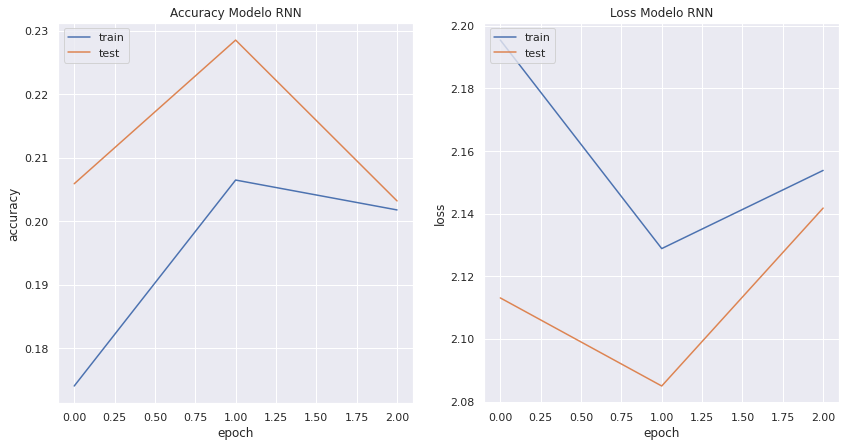

In [ ]:
graphLearningCurve(hist1, 'RNN')

### LSTM

In [ ]:
model2 = Sequential()

model2.add(LSTM(32, input_shape=(x_train.shape[1:]), return_sequences=True)) #Sin función de activación ya que se está trabajando con CuDNNLSTM. Se activa cuando no se especifica.
model2.add(Dropout(0.2))
model2.add(LSTM(32))
model2.add(Dropout(0.2))
model2.add(Flatten())
model2.add(Dense(32,activation='relu'))
model2.add(Dropout(0.2))
model2.add(Dense(10,activation='softmax'))

opt = tf.keras.optimizers.Adam(lr = 1e-3, decay=1e-5)

model2.compile(loss='sparse_categorical_crossentropy',
               optimizer=opt,
               metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(x_train,y_train,epochs=3,validation_data=(x_test,y_test))

Epoch 1/3
1563/1563 [==============================] - 1202s 769ms/step - loss: 2.2168 - accuracy: 0.1659 - val_loss: 2.2959 - val_accuracy: 0.1051
Epoch 2/3
1563/1563 [==============================] - 1203s 770ms/step - loss: 2.2192 - accuracy: 0.1600 - val_loss: 2.1633 - val_accuracy: 0.2024
Epoch 3/3
1563/1563 [==============================] - 1202s 769ms/step - loss: 2.1578 - accuracy: 0.2014 - val_loss: 2.1369 - val_accuracy: 0.2100


#### Evaluando LSTM

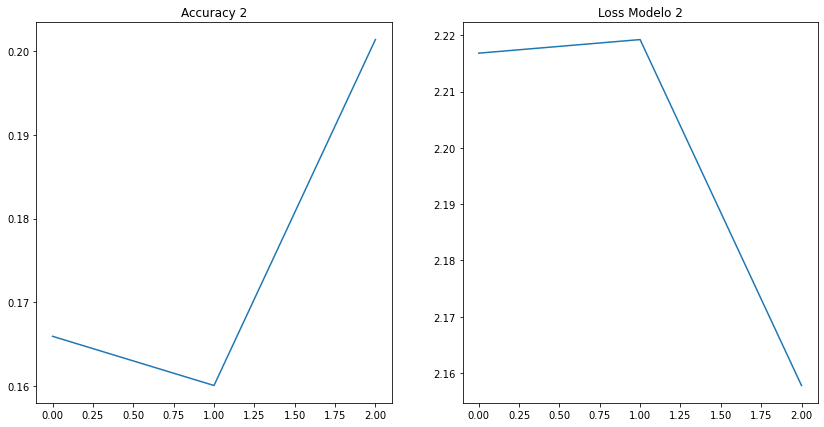

In [ ]:
plt.figure(figsize=[14,7])
ax= plt.subplot(1,2,1)
plt.plot(hist2.history['accuracy'])
plt.title('Accuracy 2')
ax= plt.subplot(1,2,2)
plt.plot(hist2.history['loss'])
plt.title('Loss Modelo 2')
plt.show()

### Red Neuronal Convolucional

In [ ]:
img_size = 32

In [ ]:
cnn = Sequential()

X_test_cnn = x_test
X_train_cnn = x_train
y_train_cnn = y_train
y_test_cnn = y_test

X_train_cnn = x_train.reshape(-1, img_size, img_size, 3)
X_test_cnn = x_test.reshape(-1, img_size, img_size, 3)
# revisión
print(X_train_cnn.shape)

cnn.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3))) 
cnn.add(MaxPooling2D(pool_size=(2, 2)))
cnn.add(Flatten())         
cnn.add(Dense(64, activation='sigmoid'))
cnn.add(Dropout(rate=0.1)) 
cnn.add(Dense(10, activation='softmax'))
    
cnn.compile( 
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
    )

cnn.summary()

(50000, 32, 32, 3)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 7200)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                460864    
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                650       
Total params: 462,410
Trainable params: 462,410
Non-trainable params: 0
_____________________________

In [ ]:
# entrenamiento y validación del modelo
n_epochs=10
hist3 = cnn.fit(
    X_train_cnn,
    to_categorical(y_train_cnn),
    epochs=n_epochs,  
    validation_data=(X_test_cnn, to_categorical(y_test_cnn)), 
    batch_size=32
)

Epoch 1/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.5102 - accuracy: 0.4622 - val_loss: 1.2614 - val_accuracy: 0.5558
Epoch 2/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.2117 - accuracy: 0.5720 - val_loss: 1.1599 - val_accuracy: 0.5882
Epoch 3/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0952 - accuracy: 0.6142 - val_loss: 1.1157 - val_accuracy: 0.6046
Epoch 4/10
1563/1563 [==============================] - 36s 23ms/step - loss: 1.0057 - accuracy: 0.6443 - val_loss: 1.0791 - val_accuracy: 0.6137
Epoch 5/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.9370 - accuracy: 0.6715 - val_loss: 1.0523 - val_accuracy: 0.6315
Epoch 6/10
1563/1563 [==============================] - 37s 23ms/step - loss: 0.8731 - accuracy: 0.6949 - val_loss: 1.0572 - val_accuracy: 0.6308
Epoch 7/10
1563/1563 [==============================] - 36s 23ms/step - loss: 0.8163 - accuracy: 0.7145 - val_loss: 1.0151 -

#### Evaluando CNN

In [ ]:
# impresión de precisión, recall y f1-score
y_pred = cnn.predict(X_test_cnn, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_test_cnn, y_pred_cate))

313/313 [==============================] - 2s 8ms/step
              precision    recall  f1-score   support

           0       0.73      0.66      0.69      1000
           1       0.77      0.76      0.77      1000
           2       0.60      0.43      0.50      1000
           3       0.47      0.49      0.48      1000
           4       0.63      0.54      0.58      1000
           5       0.52      0.60      0.56      1000
           6       0.61      0.83      0.71      1000
           7       0.70      0.72      0.71      1000
           8       0.77      0.76      0.76      1000
           9       0.72      0.70      0.71      1000

    accuracy                           0.65     10000
   macro avg       0.65      0.65      0.65     10000
weighted avg       0.65      0.65      0.65     10000



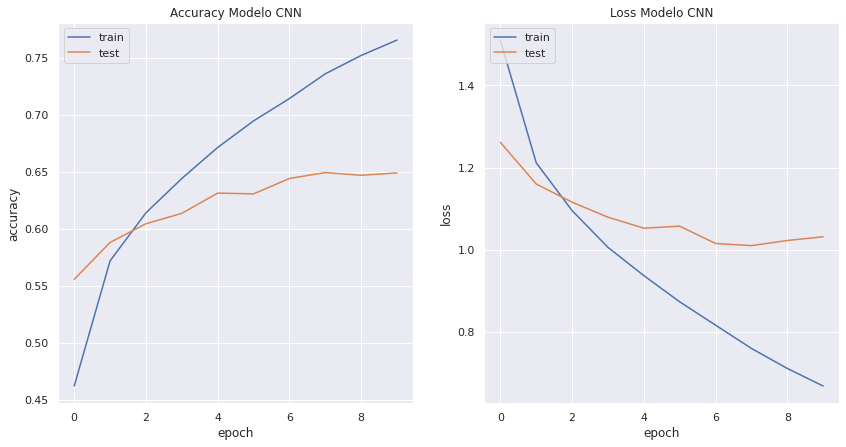

In [ ]:
graphLearningCurve(hist3, 'CNN')

### Multi Layer Perceptron

In [ ]:
x_train = x_train.reshape(50000,3072)
x_test = x_test.reshape(10000,3072)

In [ ]:
mlp = Sequential()
mlp.add(Dense(128, activation='relu', input_dim=3072))
mlp.add(Dense(64, activation='sigmoid'))  
mlp.add(Dense(10, activation='softmax'))

mlp.compile(
  optimizer='adam',
  loss='categorical_crossentropy',
  metrics=['accuracy'],
)

mlp.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 128)               393344    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 10)                650       
Total params: 402,250
Trainable params: 402,250
Non-trainable params: 0
_________________________________________________________________


In [ ]:
n_epochs=10
hist4 = mlp.fit(
    x_train,
    to_categorical(y_train),
    epochs=n_epochs,
    validation_data=(x_test, to_categorical(y_test)), 
    batch_size=32
)

Epoch 1/10
1563/1563 [==============================] - 8s 5ms/step - loss: 1.8692 - accuracy: 0.3222 - val_loss: 1.7066 - val_accuracy: 0.3837
Epoch 2/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6806 - accuracy: 0.3965 - val_loss: 1.6056 - val_accuracy: 0.4232
Epoch 3/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.6044 - accuracy: 0.4263 - val_loss: 1.5676 - val_accuracy: 0.4355
Epoch 4/10
1563/1563 [==============================] - 7s 4ms/step - loss: 1.5556 - accuracy: 0.4469 - val_loss: 1.5680 - val_accuracy: 0.4375
Epoch 5/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.5199 - accuracy: 0.4589 - val_loss: 1.5352 - val_accuracy: 0.4496
Epoch 6/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4902 - accuracy: 0.4682 - val_loss: 1.4920 - val_accuracy: 0.4683
Epoch 7/10
1563/1563 [==============================] - 7s 5ms/step - loss: 1.4690 - accuracy: 0.4758 - val_loss: 1.5512 - val_accuracy:

#### Evaluando MLP

In [ ]:
# impresión de precisión, recall y f1-score
y_pred = mlp.predict(x_test, batch_size=32, verbose=1)
y_pred_cate = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_cate))

313/313 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.48      0.66      0.55      1000
           1       0.59      0.60      0.60      1000
           2       0.33      0.38      0.35      1000
           3       0.36      0.24      0.29      1000
           4       0.47      0.30      0.37      1000
           5       0.37      0.38      0.38      1000
           6       0.46      0.62      0.53      1000
           7       0.50      0.57      0.53      1000
           8       0.72      0.49      0.59      1000
           9       0.56      0.53      0.55      1000

    accuracy                           0.48     10000
   macro avg       0.48      0.48      0.47     10000
weighted avg       0.48      0.48      0.47     10000



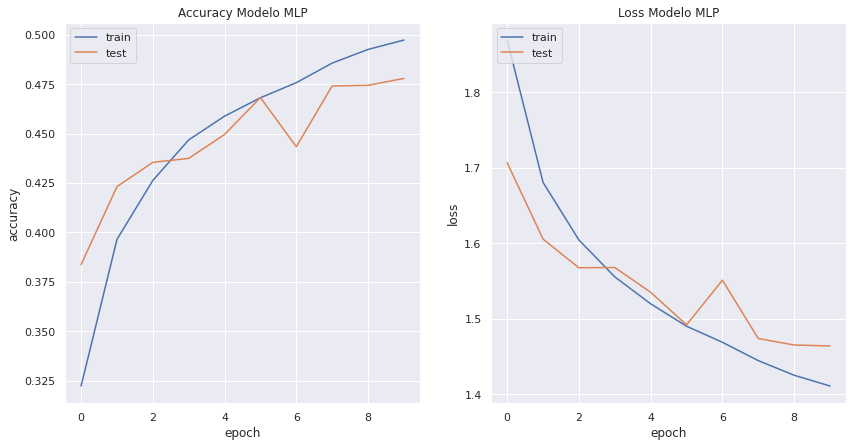

In [ ]:
graphLearningCurve(hist4, 'MLP')

### Naive Bayes

In [ ]:
x = np.concatenate((x_train, x_test))
y = np.concatenate((y_train, y_test))
y = y.reshape(60000)

In [ ]:
NB = MultinomialNB()
NB.fit(x_train, y_train)
y_pred = NB.predict(x_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.43      0.38      0.40      1000
           1       0.34      0.18      0.23      1000
           2       0.31      0.14      0.20      1000
           3       0.26      0.10      0.14      1000
           4       0.28      0.18      0.22      1000
           5       0.22      0.43      0.29      1000
           6       0.33      0.33      0.33      1000
           7       0.23      0.26      0.24      1000
           8       0.34      0.44      0.38      1000
           9       0.29      0.51      0.37      1000

    accuracy                           0.29     10000
   macro avg       0.30      0.29      0.28     10000
weighted avg       0.30      0.29      0.28     10000



In [ ]:
alpha = [0.01, 0.1, 0.5, 1.0, 10.0]

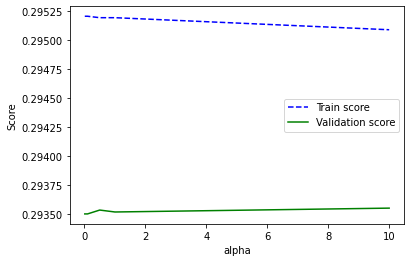

In [ ]:
plotingValidationCurve(NB, x, y, 'alpha', alpha, 5, 'accuracy')

In [ ]:
param_grid = {'alpha': np.linspace(0.1,3,20)}

In [ ]:
grid = GridSearchCV(MultinomialNB(), param_grid, cv=5)
grid.fit(x, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=MultinomialNB(alpha=1.0, class_prior=None,
                                     fit_prior=True),
             iid='deprecated', n_jobs=None,
             param_grid={'alpha': array([0.1       , 0.25263158, 0.40526316, 0.55789474, 0.71052632,
       0.86315789, 1.01578947, 1.16842105, 1.32105263, 1.47368421,
       1.62631579, 1.77894737, 1.93157895, 2.08421053, 2.23684211,
       2.38947368, 2.54210526, 2.69473684, 2.84736842, 3.        ])},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [ ]:
model = grid.best_estimator_
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


              precision    recall  f1-score   support

           0       0.43      0.38      0.40      1000
           1       0.33      0.18      0.23      1000
           2       0.31      0.14      0.20      1000
           3       0.26      0.10      0.14      1000
           4       0.28      0.18      0.22      1000
           5       0.22      0.43      0.29      1000
           6       0.33      0.33      0.33      1000
           7       0.23      0.26      0.24      1000
           8       0.34      0.44      0.38      1000
           9       0.29      0.51      0.37      1000

    accuracy                           0.29     10000
   macro avg       0.30      0.29      0.28     10000
weighted avg       0.30      0.29      0.28     10000



### Decision Tree Classifier

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(x_train, y_train)
y_pred = tree.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.33      0.36      0.35      1000
           1       0.28      0.26      0.27      1000
           2       0.20      0.22      0.21      1000
           3       0.19      0.18      0.18      1000
           4       0.22      0.23      0.23      1000
           5       0.22      0.22      0.22      1000
           6       0.29      0.28      0.28      1000
           7       0.27      0.26      0.27      1000
           8       0.37      0.39      0.38      1000
           9       0.29      0.28      0.28      1000

    accuracy                           0.27     10000
   macro avg       0.27      0.27      0.27     10000
weighted avg       0.27      0.27      0.27     10000



## Modelo No Supervisado KMeans

In [ ]:
x.shape

(60000, 3072)

In [ ]:
km = KMeans(n_clusters=10)
clusters = km.fit_predict(x)

In [ ]:
labels = np.zeros_like(clusters)
for i in range(10):
  mask = (clusters == i)
  labels[mask] = mode(y[mask])[0]

In [ ]:
print("Accuracy del modelo KMeans")
accuracy_score(y, labels)

Accuracy del modelo KMeans


0.22086666666666666